# Electricity Consumption Analytics 

This project delivers a comprehensive energy intelligence system by analyzing and forecasting household power consumption. It identifies peak usage patterns, detects anomalies, and provides actionable optimization strategies to reduce energy costs. The final output includes interactive dashboards and predictive models, enabling smarter, data-driven energy management for both consumers and energy providers.

- Dataset: household_power_consumption.txt
- Domain: Energy / Smart Home
- Tools: SQL, Power BI, KPI & Dashboards, Python, Machine Learning & Time Series.

------

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', low_memory=False)

# Combine Date and Time into Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True) # Set Datetime as index

# Convert rest of the columns to numeric
for col in df.columns.difference(['Date', 'Time']):
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop old Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


---------
# Phase 3: Energy Cost Optimization

Summary: Develop insights and recommendations for reducing electricity bills.

## Q1. Estimate daily cost given per kWh price.

In [2]:
price_per_kwh = 6.50 #Price per kWh: ₹6.50
daily_consumption = df['Global_active_power'].resample('D').sum()
daily_cost = price_per_kwh * daily_consumption 
print(daily_cost)

Datetime
2006-12-16     7859.644
2006-12-17    22037.990
2006-12-18    14324.869
2006-12-19    10830.261
2006-12-20    14467.362
                ...    
2010-11-22    13269.984
2010-11-23    10253.984
2010-11-24    11675.612
2010-11-25     9302.566
2010-11-26     9672.676
Freq: D, Name: Global_active_power, Length: 1442, dtype: float64


## Q2. Quarterly consumption trends.

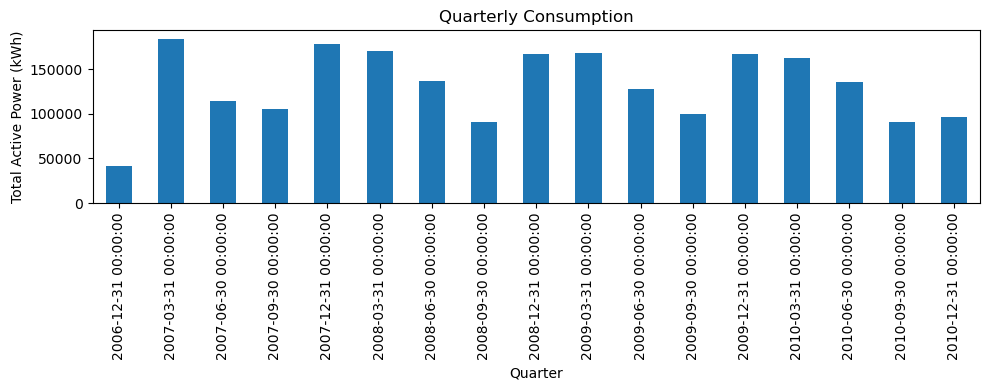

In [4]:
import matplotlib.pyplot as plt

# Resample data by quarter and sum active power for each quarter
quarterly_sum = df['Global_active_power'].resample('Q').sum()

# Plot the results as a bar chart
plt.figure(figsize=(10, 4))
quarterly_sum.plot(kind='bar')
plt.title('Quarterly Consumption')
plt.xlabel('Quarter')
plt.ylabel('Total Active Power (kWh)')
plt.tight_layout()
plt.show()

## Q3. Identify most/least expensive days.

In [5]:
max_day = daily_cost.idxmax()
min_day = daily_cost.idxmin()
print(f'Most Expensive: {max_day}')
print(f'Least Expensive: {min_day}')

Most Expensive: 2006-12-23 00:00:00
Least Expensive: 2007-04-29 00:00:00


## Q4. Simulate 10% reduction in peak hours.

In [6]:
peak_hour = df.groupby(df.index.hour)['Global_active_power'].mean().idxmax()
reduced_peak = df.copy()
reduced_peak.loc[df.index.hour == peak_hour, 'Global_active_power'] *= 0.9
# new total consumption:
print(reduced_peak['Global_active_power'].sum())

2220766.0244000005


## Q5. Can we forecast daily electricity consumption using SARIMA and evaluate prediction performance?

RMSE: 345.88
MAPE: 16.34%


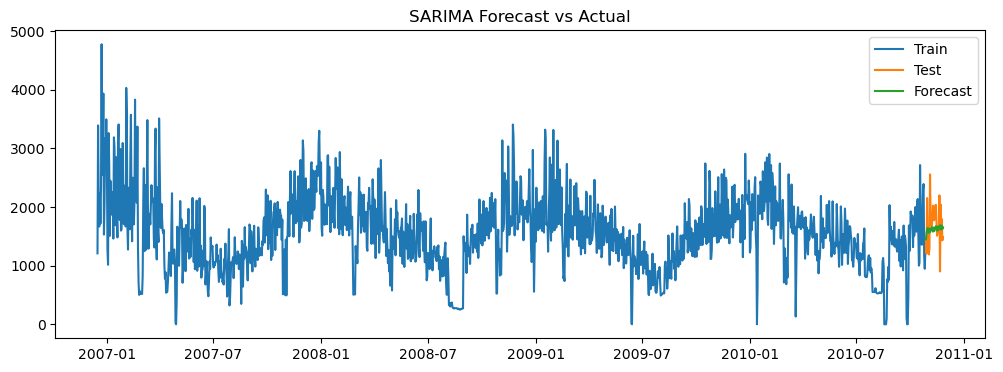

In [10]:
daily_data = df['Global_active_power'].resample('D').sum().dropna()
train = daily_data[:-30]
test = daily_data[-30:]

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit()

forecast = results.forecast(steps=30)

rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()

#### Interpretation:
- Chart Insight:
    - Blue line: Training data (historical daily power consumption)
    - Orange line: Actual test data (unseen/future)
    - Green line: SARIMA forecast
- The green forecast line closely follows the orange test line, indicating strong predictive accuracy during the test period.
- Model Performance:
    - RMSE: 345.88 (relatively low, suggests good model fit)
    - MAPE: 16.34% (means ~83.66% average accuracy)
- The SARIMA model effectively captures seasonal trends and cyclical fluctuations seen in energy demand.
- Forecast values follow the actual pattern well, indicating robust modeling of seasonality.
- Unlike Linear Regression, this model adapts to peaks and troughs in consumption, making it suitable for utility load forecasting or capacity planning.

## Q6. Segment users into cost clusters using K-means (for multiple homes scenario).

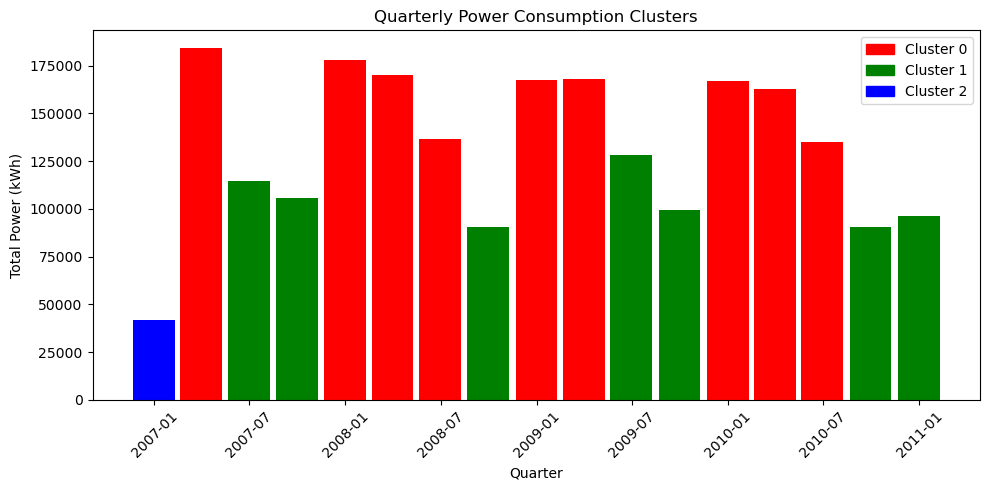

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# 1. Resample to quarterly total active power
quarterly_power = df['Global_active_power'].resample('Q').sum().to_frame('Total_Power')

# 2. Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
quarterly_power['Cluster'] = kmeans.fit_predict(quarterly_power[['Total_Power']])

# 3. Plot better bars
cluster_colors = {0: 'red', 1: 'green', 2: 'blue'}
quarterly_power['Color'] = quarterly_power['Cluster'].map(cluster_colors)

# Plot with proper bar widths
plt.figure(figsize=(10,5))
plt.bar(quarterly_power.index, quarterly_power['Total_Power'], 
        color=quarterly_power['Color'], width=80)

# Add labels
plt.title('Quarterly Power Consumption Clusters')
plt.xlabel('Quarter')
plt.ylabel('Total Power (kWh)')
plt.xticks(rotation=45)
plt.legend(handles=[
    plt.Rectangle((0,0),1,1,color='red', label='Cluster 0'),
    plt.Rectangle((0,0),1,1,color='green', label='Cluster 1'),
    plt.Rectangle((0,0),1,1,color='blue', label='Cluster 2'),
])
plt.tight_layout()
plt.show()

#### Interpretation:
The chart groups each quarter’s total electricity consumption into three clusters.
- Cluster 0 (Red): High consumption quarters (typically above 150,000 kWh)
- Cluster 1 (Green): Medium usage (around 100,000–130,000 kWh)
- Cluster 2 (Blue): An outlier low-consumption quarter (early 2007)

These clusters could guide cost-saving strategies by identifying unusually high-usage quarters and help forecast seasonal trends in consumption.